In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from helperbot.lr_finder import LRFinder
from main import (
    get_seresnet_model, MixUpSoftmaxLoss, 
    WeightDecayOptimizerWrapper, NO_DECAY, N_CLASSES, DATA_ROOT,
    build_dataframe_from_folder, TrainDataset, train_transform
)

/home/ceshine/miniconda3/envs/deep/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def make_loader(batch_size, ds_class, df: pd.DataFrame, image_transform, drop_last=False, shuffle=False) -> DataLoader:
    return DataLoader(
        ds_class(df, image_transform),
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=4,
        drop_last=drop_last
    )

In [3]:
criterion = MixUpSoftmaxLoss(nn.CrossEntropyLoss())
model = get_seresnet_model(
    arch="se_resnext50_32x4d",
    n_classes=N_CLASSES, pretrained=False).cuda()
optimizer = WeightDecayOptimizerWrapper(
    torch.optim.Adam(
        [
            {
                'params': [p for n, p in model.named_parameters()
                           if not any(nd in n for nd in NO_DECAY)],
            },
            {
                'params': [p for n, p in model.named_parameters()
                           if any(nd in n for nd in NO_DECAY)],
            }
        ],
        weight_decay=0,
        lr=1e-1
    ),
    weight_decay=[1e-1, 0],
    change_with_lr=True
)
finder = LRFinder(model, optimizer, criterion)

5,610,928 | 19,899,968 | 2,260,047


In [4]:
train_dir = DATA_ROOT / 'train'
df_train, class_map = build_dataframe_from_folder(train_dir)

train_loader = make_loader(
    32, TrainDataset, df_train, train_transform, drop_last=True, shuffle=True)
len(train_loader)

402

In [5]:
finder.range_test(
    train_loader, 
    min_lr_ratio=1e-4, 
    total_steps=len(train_loader),
    ma_decay=0.9, stop_ratio = 10
)


Learning rate search finished. See the graph with {finder_name}.plot()


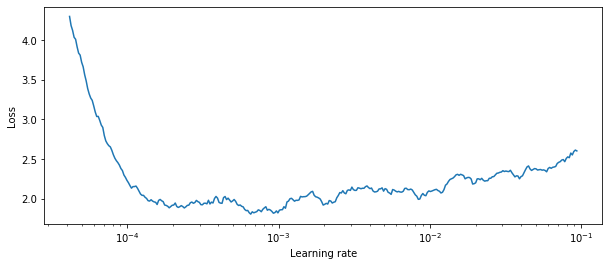

In [10]:
finder.plot(skip_start=60, filepath="/tmp/tmp.png")